In [281]:
%matplotlib inline

import os
import time
import copy
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

import torch
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import CIFAR10
from torch import nn, optim

from sklearn.manifold import TSNE
import umap


CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
FG_CLASSES = list(map(CIFAR10_CLASSES.index, 
                 ["cat"]))
BG_CLASSES = list(map(CIFAR10_CLASSES.index, 
                 ["airplane", "automobile", "bird", "deer", "frog"]))
OOD_CLASSES = list(map(CIFAR10_CLASSES.index, 
                  ["dog", "horse", "ship", "truck"]))

NUM_CLASSES = 2
INPUT_SIZE = 224
NUM_EPOCHS = 100
BATCH_SIZE = 128
TRAIN = False

In [282]:
def create_model(kind='resnet152'):
    # Download pretrained model
    if kind == 'resnet152':
        model = models.resnet152(pretrained=True)
    elif kind == "densenet161":
        model = models.densenet161(pretrained=True)
    elif kind == "vgg16":
        model = models.vgg16(pretrained=True)
        
    # Freeze weights
    for param in model.parameters():
        param.requires_grad = False

    # Re-implement final classification layer
    if kind == 'resnet152':
        model.fc = nn.Linear(in_features=model.fc.in_features, out_features=NUM_CLASSES, bias=True)
    elif kind == "densenet161":
        model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=NUM_CLASSES, bias=True)
    elif kind == "vgg16":
        model.classifier[6] = nn.Linear(in_features=model.classifier[6].in_features, out_features=NUM_CLASSES, bias=True)

    return model


class DatasetSubset:
    """Create a new training dataset using some subset of class labels.
    
    dataset: instanceof(torch.utils.data.Dataset)
        The dataset you want to filter.
    
    inlier_labels: list or tuple:
        A list of the inlier data class labels you want to keep in
        the new dataset.
        
    transform: instanceof(torchvision.transforms)
        Any transforms you want to do to apply to the data.
        You may not need any transforms if they were already applied
        on dataset.
        
    train: bool
        Flag indicating if you are splitting the training or testing set.
    """
    def __init__(self, dataset, inlier_labels, transform=None, target_transform=None, train=True):
        super(DatasetSubset, self).__init__()

        self.inlier_labels = inlier_labels
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

        if train:
            self.inlier_indices = [
                i for i, x in enumerate(self.dataset.train_labels) 
                if x in self.inlier_labels]
        else:
            self.inlier_indices = [
                i for i, x in enumerate(self.dataset.test_labels) 
                if x in self.inlier_labels]
            
    def __len__(self):
        return len(self.inlier_indices)

    def __getitem__(self, idx):
        x, y = self.dataset[self.inlier_indices[idx]]
        
        if self.transform is not None:
            x = self.transform(x)
            
        if self.target_transform is not None:
            y = self.target_transform(y)

        return (x, y)


def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, lr_scheduler=None):
    since = time.time()

    train_acc_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in trange(num_epochs, desc="Epochs"):
        tqdm.write('Epoch {}/{}'.format(epoch, num_epochs - 1))
        tqdm.write('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], 
                                       total=len(dataloaders[phase]), 
                                       desc="{} batches".format(phase),
                                       leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            tqdm.write('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss = epoch_loss
                val_acc_history.append(epoch_acc)
            elif phase == 'train':
                train_acc_history.append(epoch_acc)
                
        if lr_scheduler is not None:
            lr_scheduler.step(val_loss)
            
        tqdm.write("\n")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history


def save_model(model, path='model.pt'):
    torch.save(model.state_dict(), path)

    
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()


def plot_training_hist(train_hist, val_hist):
    thist = []
    vhist = []

    thist = [h.cpu().numpy() for h in train_hist]
    vhist = [h.cpu().numpy() for h in val_hist]

    plt.title("Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1,NUM_EPOCHS+1),thist,label="Train")
    plt.plot(range(1,NUM_EPOCHS+1),vhist,label="Val")
#     plt.ylim((0,1.))
#     plt.xticks(np.arange(1, NUM_EPOCHS+1, 1.0))
    plt.legend()
    plt.show()
    
    
def save_history(train_hist, val_hist, train_hist_path='train_hist.pickle', val_hist_path='val_hist.pickle'):
    with open(train_hist_path, 'wb') as f:
        pickle.dump(train_hist, f)
    with open(val_hist_path, 'wb') as f:
        pickle.dump(val_hist, f)
        
        
def load_history(train_hist_path='train_hist.pickle', val_hist_path='val_hist.pickle'):
    with open(train_hist_path, 'rb') as f:
        train_hist = pickle.load(f)
    with open(val_hist_path, 'rb') as f:
        val_hist = pickle.load(f)
    return train_hist, val_hist


def extract_penultimate_features(model, dataloader, model_kind='resnet152'):
    model.eval()
    
    global conv_feats

    def get_features_hook(self, input_, output):
        data = output.cpu().detach().numpy()
        global conv_feats
        conv_feats = np.concatenate((conv_feats, data), axis=0)

    if model_kind == 'resnet152':
        conv_feats = np.empty((0, 2048, 7, 7))
        hook = model.layer4[2].conv3.register_forward_hook(get_features_hook)
    elif model_kind == 'densenet161':
        conv_feats = np.empty((0, 48, 7, 7))
        hook = model.features.denseblock4.denselayer24.conv2.register_forward_hook(get_features_hook)
    elif model_kind == 'vgg16':
        conv_feats = np.empty((0, 4096))
        hook = model.classifier[3].register_forward_hook(get_features_hook)
    
    test_labels = np.empty((0))

    # Extract features, labels
    model.eval()
    for inputs, labels in tqdm(dataloader, total=len(dataloader)):
        outputs = model(inputs.to(device))
        test_labels = np.concatenate((test_labels, labels.cpu().numpy()), axis=0)

    # Remove the hook
    hook.remove()
    
    return conv_feats, test_labels


def evaluate_model(model, dataloader):
    running_corrects = 0
    
    for inputs, labels in tqdm(dataloader, total=len(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

        # statistics
        running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / len(dataloader.dataset)
    return accuracy.detach().cpu().item()

# Implement a pretrained classifer and finetuning for CIFAR 10

## Set up data loaders

Transform the training data as follows:
    - Remove all images with labels OOD_CLASSES
    - Change the labels:
        - 0: image is in FG_CLASSES (i.e it's a cat)
        - 1: image is one of BG_CLASSES (i.e. it's a airplane, automobile, bird, deer, dog, or frog)
        
Transform the test data as follows:
    - Change the labels:
        - 0: image is in FG_CLASSES (i.e it's a cat)
        - 1: image is one of BG_CLASSES (i.e. it's a airplane, automobile, bird, deer, dog, or frog)
        - 2: image is one of OOD_CLASSES (i.e. it's a horse, ship, or truck)

In [283]:
# Set up data loaders
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

def label_transform(y):
    if y in FG_CLASSES: return 0
    elif y in BG_CLASSES: return 1
    else: return 2

cifar10_train = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar100/', train=True, transform=data_transforms['train'])
cifar10_train = DatasetSubset(cifar10_train, inlier_labels=FG_CLASSES+BG_CLASSES, train=True, target_transform=label_transform)

cifar10_test = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar100/', train=False, transform=data_transforms['val'])
cifar10_test = DatasetSubset(cifar10_test, inlier_labels=FG_CLASSES+BG_CLASSES, train=False, target_transform=label_transform)

cifar10_ood = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar100/', train=False, transform=data_transforms['val'],target_transform=label_transform)

dataloaders_dict = {
    'train': torch.utils.data.DataLoader(cifar10_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(cifar10_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'ood': torch.utils.data.DataLoader(cifar10_ood, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = create_model("vgg16")
model = model.to(device)

## Define optimization objective, optimizer, etc

In [284]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=5)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


## Train and evaluate

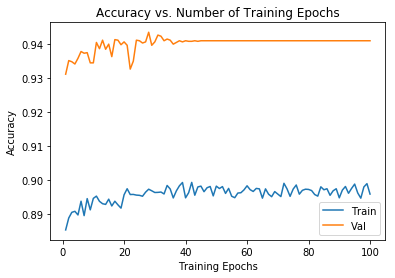

In [285]:
if TRAIN:
    # Train and evaluate
    model, val_hist, train_hist = train_model(
        model, 
        dataloaders_dict, 
        criterion, 
        optimizer_ft, 
        num_epochs=NUM_EPOCHS,
        lr_scheduler=scheduler_ft)
    save_model(model, path='vgg16_2.pt')
    save_history(train_hist, val_hist, 'train_hist_2.pickle', 'val_hist_2.pickle')
else:
    load_model(model, path='vgg16_2.pt')
    train_hist, val_hist = load_history('train_hist_2.pickle', 'val_hist_2.pickle')

plot_training_hist(train_hist, val_hist)    

## Fine tune top convolutional layers

In [286]:
# print(model)

# Freeze weights
for param in model.parameters():
    param.requires_grad = False
    
# Unfreeze top layers
for param in model.features[23:].parameters():
    param.requires_grad = True
    
for param in model.classifier.parameters():
    param.requires_grad = True

In [287]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=1e-4, momentum=0.9)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=5)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


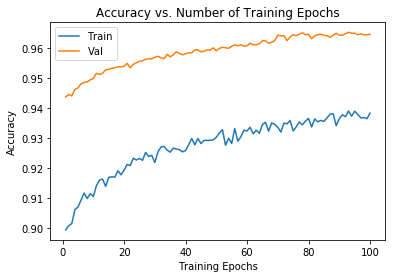

In [288]:
if TRAIN:
    # Train and evaluate
    model, val_hist, train_hist = train_model(model, 
                                              dataloaders_dict, 
                                              criterion, 
                                              optimizer_ft, 
                                              num_epochs=NUM_EPOCHS,
                                              lr_scheduler=scheduler_ft)
    save_model(model, path='vgg16_fine_2.pt')
    save_history(train_hist, val_hist, 'train_hist_fine_2.pickle', 'val_hist_fine_2.pickle')
    
else:
    load_model(model, path='vgg16_fine_2.pt')
    train_hist, val_hist = load_history('train_hist_fine_2.pickle', 'val_hist_fine_2.pickle')

plot_training_hist(train_hist, val_hist)

In [289]:
print("Model accuracy:", evaluate_model(model, dataloaders_dict['val'])) 

Model accuracy: 0.9651666666666666


# OOD dataset visualizations

## Visual separability of classes using softmax

In [290]:
from torch.nn import functional as F

softmax_outputs = np.empty((0,2))
test_labels = np.empty((0,))

for x, y in dataloaders_dict['ood']:
    output = model(x.cuda())
    softmax_out = F.softmax(output, dim=1)
    softmax_out = softmax_out.detach().cpu().numpy()
    softmax_outputs = np.concatenate((softmax_outputs, softmax_out), axis=0)
    test_labels = np.concatenate((test_labels, y.detach().cpu().numpy()), axis=0)    

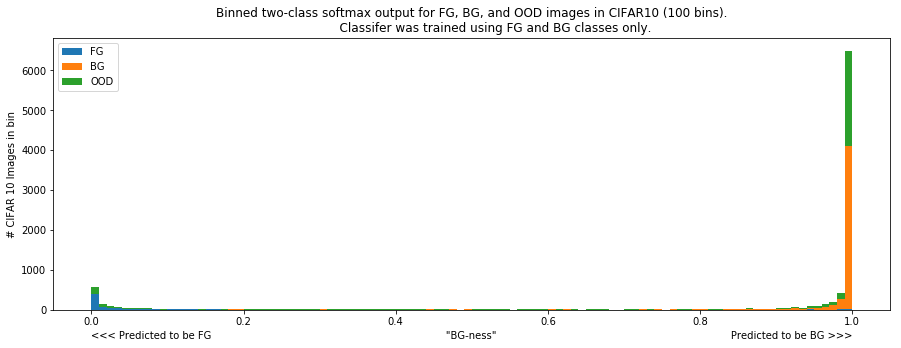

In [291]:
plt.figure(figsize=(15, 5))

fg_points = softmax_outputs[:,1][test_labels == 0]
bg_points = softmax_outputs[:,1][test_labels == 1]
ood_points = softmax_outputs[:,1][test_labels == 2] 

plt.hist((fg_points, bg_points, ood_points), bins=100, stacked=True, log=False, label=["FG", "BG", "OOD"])
plt.xlabel('<<< Predicted to be FG' + " "*75 + "\"BG-ness\"" + " "*75 + 'Predicted to be BG >>>')
plt.ylabel('# CIFAR 10 Images in bin')
plt.title("""Binned two-class softmax output for FG, BG, and OOD images in CIFAR10 (100 bins).
            Classifer was trained using FG and BG classes only.""")
plt.legend()
plt.show()

In [292]:
# plt.figure(figsize=(15, 5))

# fg_points = softmax_outputs[:,1][test_labels == 0]
# bg_points = softmax_outputs[:,1][test_labels == 1]
# ood_points = softmax_outputs[:,1][test_labels == 2] 

# plt.hist((fg_points, bg_points, ood_points), bins=100, stacked=True, log=True, label=["FG", "BG", "OOD"])
# plt.xlabel('<<< Predicted to be FG' + " "*75 + "\"BG-ness\"" + " "*75 + 'Predicted to be BG >>>')
# plt.ylabel('# CIFAR 10 Images')
# plt.title("""Binned two-class softmax output for FG, BG, and OOD images in CIFAR10 (100 bins).
#             Classifer was trained using FG and BG classes only.""")
# plt.legend()
# plt.show()

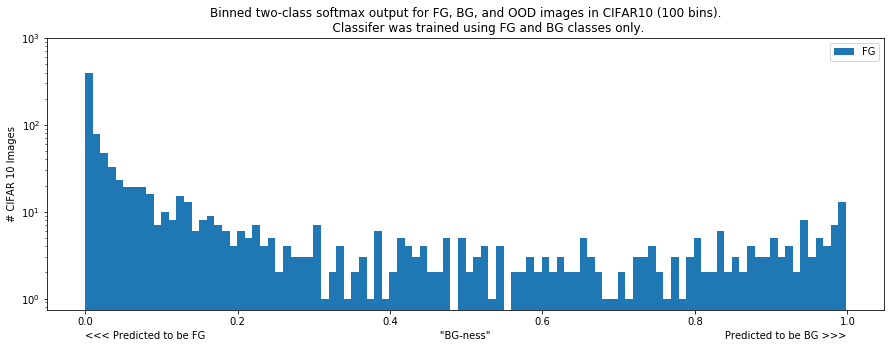

In [293]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(figsize=(15, 5))

plt.hist(fg_points, bins=100, color=colors[0], log=True, label=["FG"])
plt.xlabel('<<< Predicted to be FG' + " "*75 + "\"BG-ness\"" + " "*75 + 'Predicted to be BG >>>')
plt.ylabel('# CIFAR 10 Images')
plt.title("""Binned two-class softmax output for FG, BG, and OOD images in CIFAR10 (100 bins).
            Classifer was trained using FG and BG classes only.""")
plt.yticks([10**x for x in range(4)])
plt.legend()
plt.show()

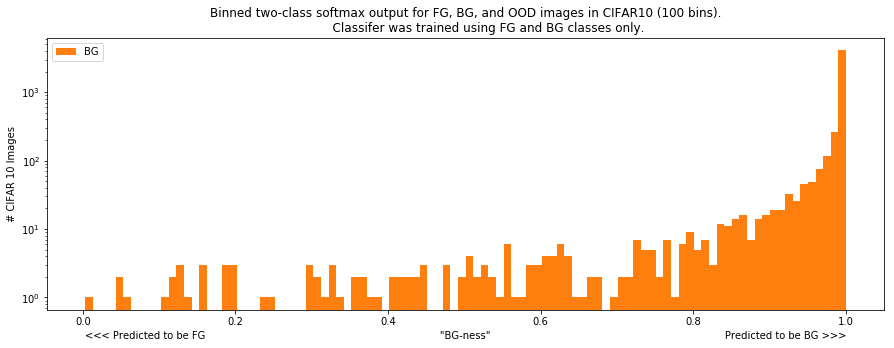

In [294]:
plt.figure(figsize=(15, 5))

plt.hist(bg_points, bins=100, color=colors[1], log=True, label=["BG"])
plt.xlabel('<<< Predicted to be FG' + " "*75 + "\"BG-ness\"" + " "*75 + 'Predicted to be BG >>>')
plt.ylabel('# CIFAR 10 Images')
plt.title("""Binned two-class softmax output for FG, BG, and OOD images in CIFAR10 (100 bins).
            Classifer was trained using FG and BG classes only.""")
plt.yticks([10**x for x in range(4)])
plt.legend()
plt.show()

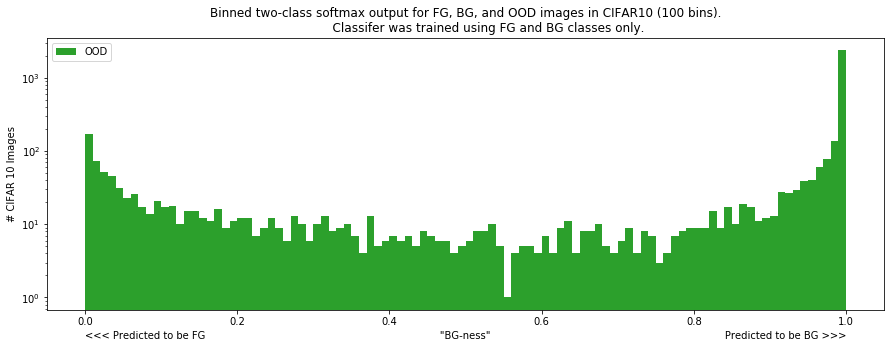

In [295]:
plt.figure(figsize=(15, 5))

plt.hist(ood_points, bins=100, color=colors[2], log=True, label=["OOD"])
plt.xlabel('<<< Predicted to be FG' + " "*75 + "\"BG-ness\"" + " "*75 + 'Predicted to be BG >>>')
plt.ylabel('# CIFAR 10 Images')
plt.title("""Binned two-class softmax output for FG, BG, and OOD images in CIFAR10 (100 bins).
            Classifer was trained using FG and BG classes only.""")
plt.yticks([10**x for x in range(4)])
plt.legend()
plt.show()

## Penultimate feature space

### UMAP Visualization

In [296]:
# Get penultimate features and labels from test set
conv_feats, test_labels = extract_penultimate_features(model, dataloaders_dict['ood'], 'vgg16')
embedding = umap.UMAP().fit_transform(conv_feats.reshape(conv_feats.shape[0], -1))

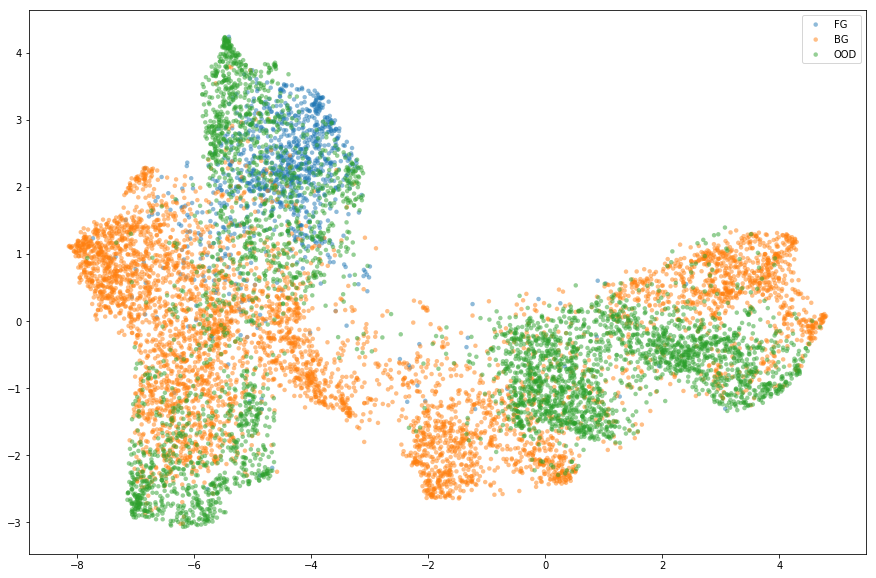

In [297]:
fig, ax = plt.subplots(figsize=(15, 10))
labels = ['FG', 'BG', 'OOD']

for label in range(len(labels)):
    x = embedding[:,0][test_labels == label]
    y = embedding[:,1][test_labels == label]
    ax.scatter(x, y, c=colors[label], s=20, label=labels[label], alpha=0.5, edgecolors='none')

ax.legend()
plt.show()

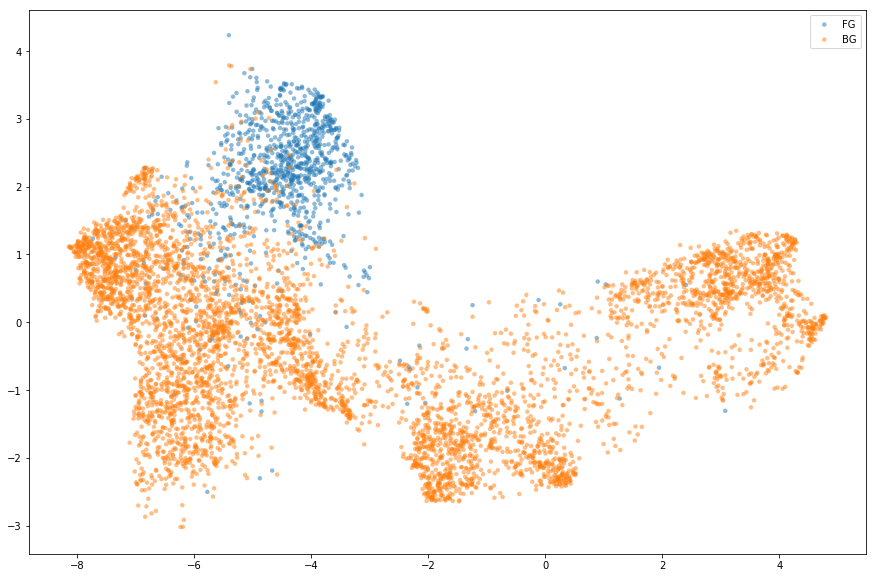

In [298]:
fig, ax = plt.subplots(figsize=(15, 10))
labels = ['FG', 'BG']

for label in range(len(labels)):
    x = embedding[:,0][test_labels == label]
    y = embedding[:,1][test_labels == label]
    ax.scatter(x, y, c=colors[label], s=20, label=labels[label], alpha=0.5, edgecolors='none')

ax.legend()
plt.show()